# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')
import shutil
path = './models'
if os.path.isdir(path): 
    shutil.rmtree(path)

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
all_time =3000
start_time = 0
Time = 15
neuron_num = 62
datax = scipy.io.loadmat("spike62_k09_9000.mat")
y_data = datax["spike62_k09_9000"][:,start_time:all_time].T
traj = scipy.io.loadmat("trj62_k09_9000.mat")
traj = traj["trj62_k09_9000"][:,start_time:all_time].T
NRep=int((all_time-start_time)/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(all_time-start_time):
    for j in range(neuron_num):
        if y_data[i][j] > 20:
            y_data[i][j] = 20
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

(3000, 62)
torch.Size([200, 15, 62])


## View example Ground Truth Firing Rates

(15, 62)


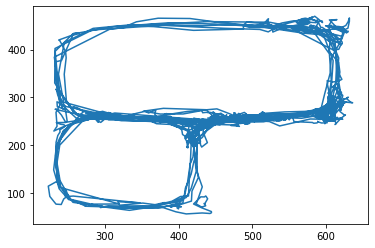

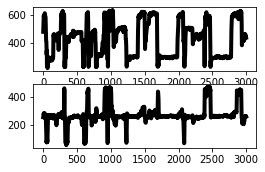

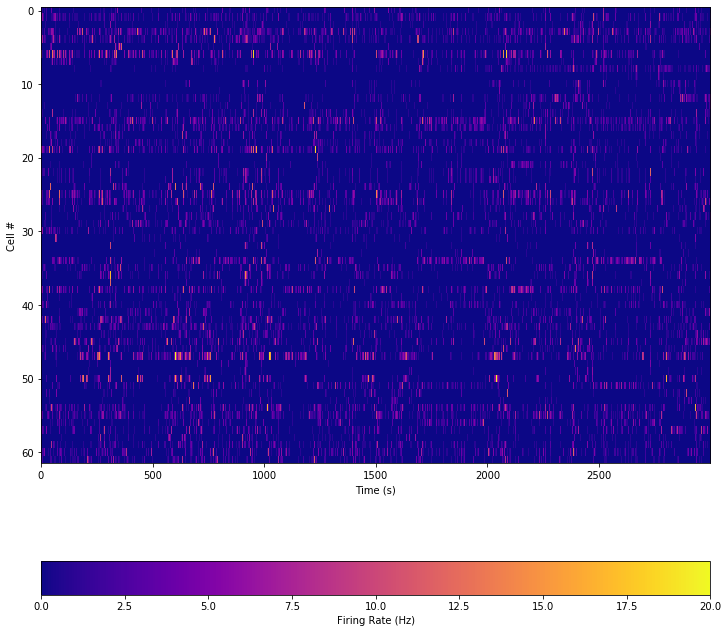

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

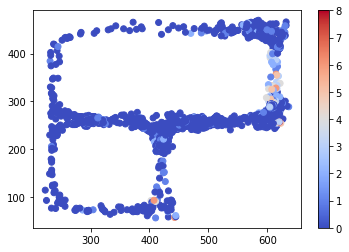

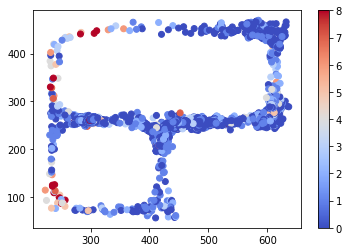

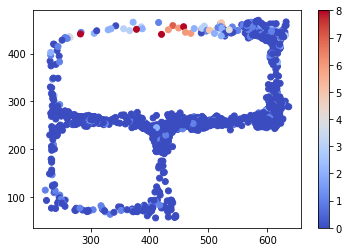

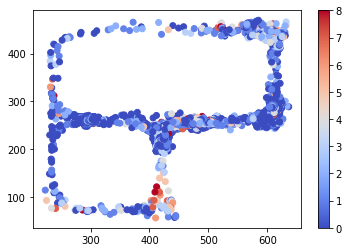

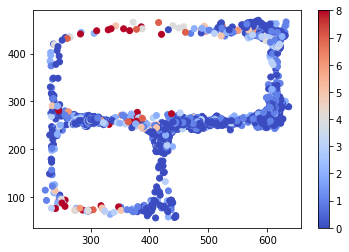

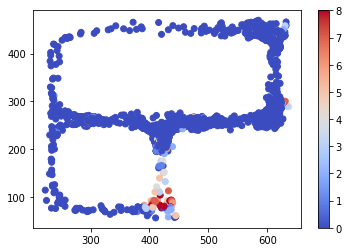

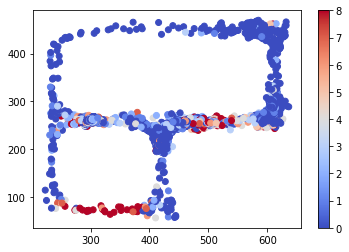

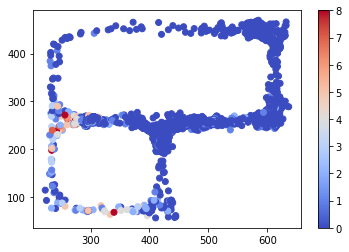

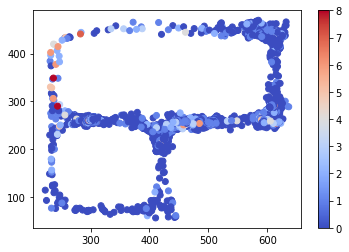

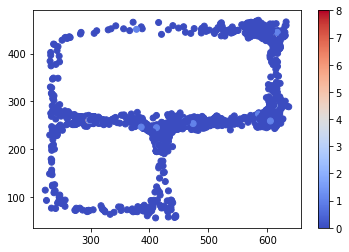

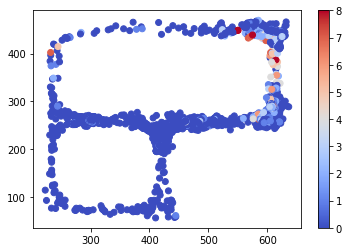

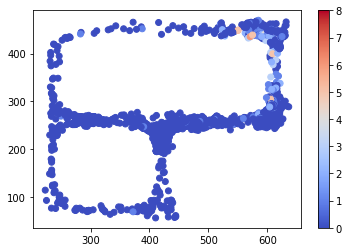

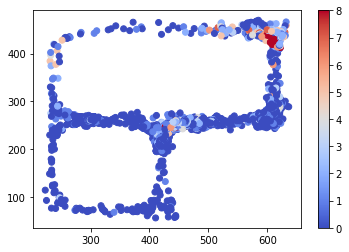

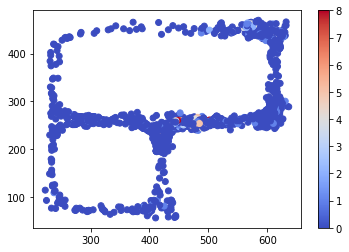

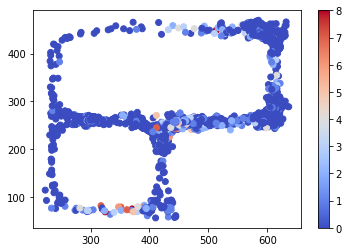

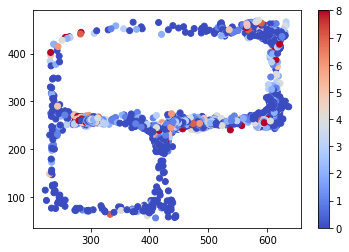

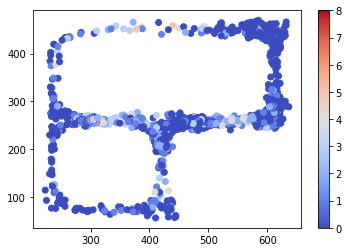

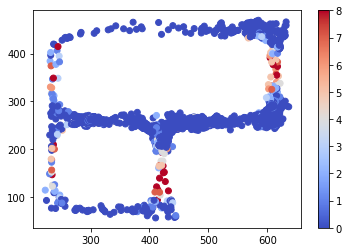

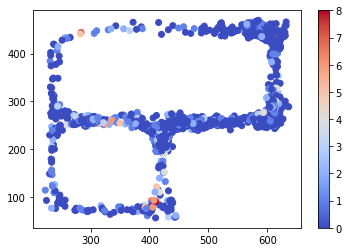

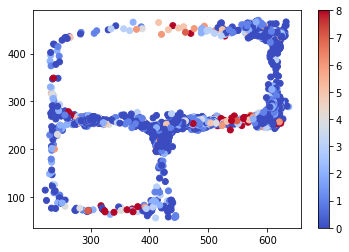

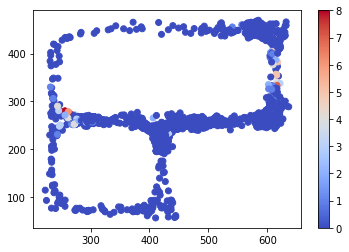

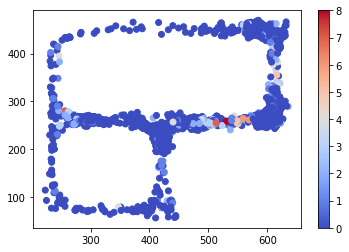

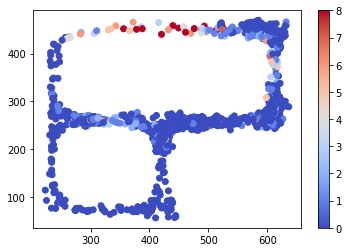

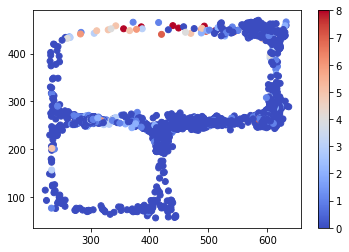

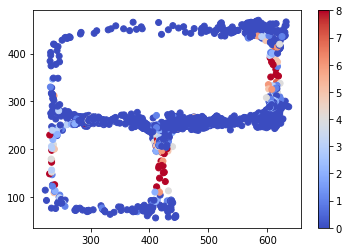

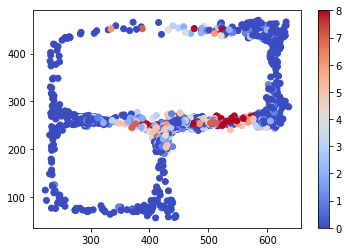

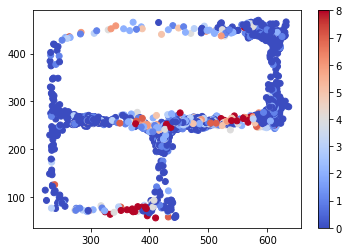

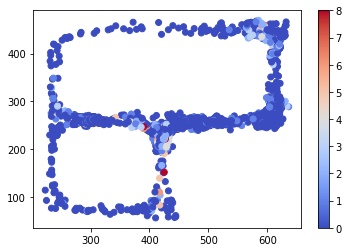

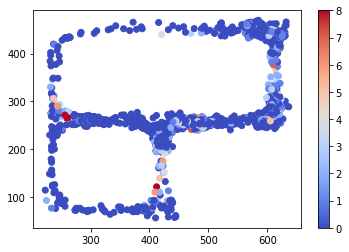

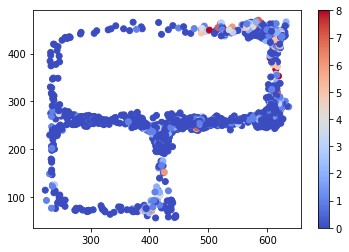

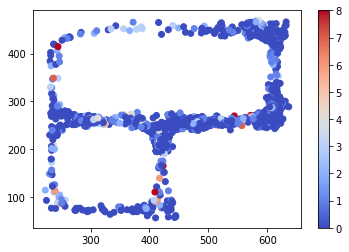

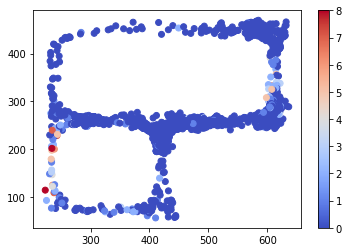

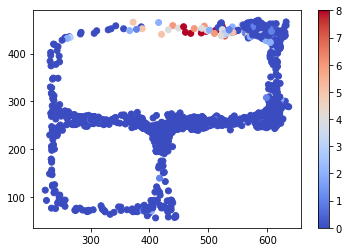

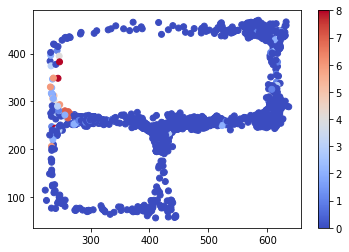

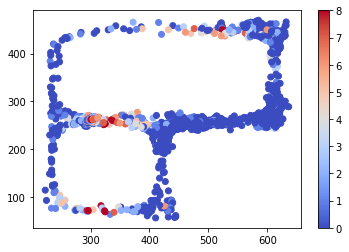

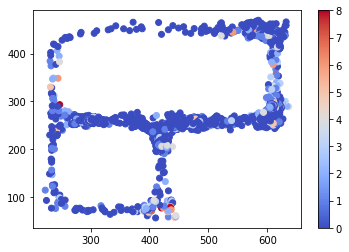

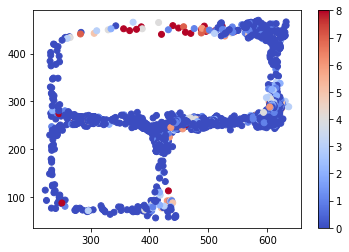

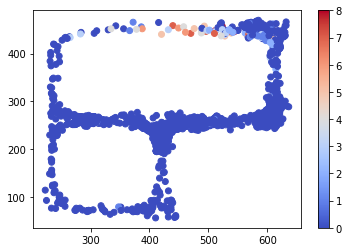

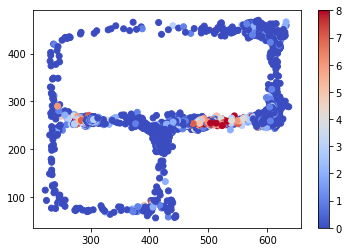

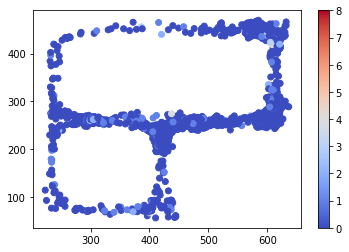

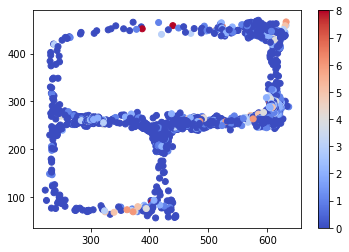

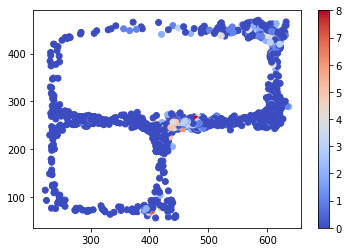

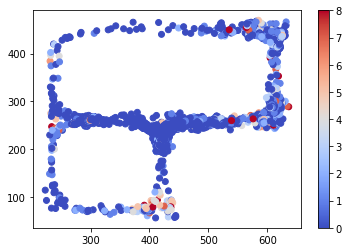

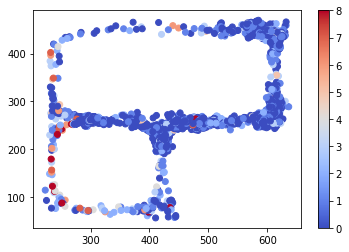

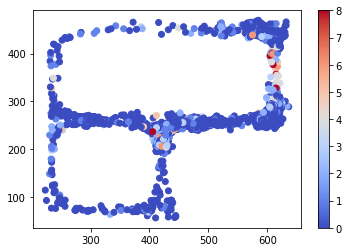

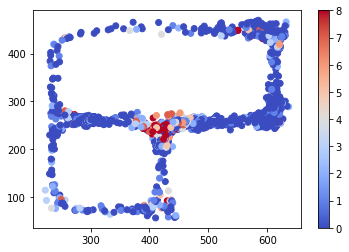

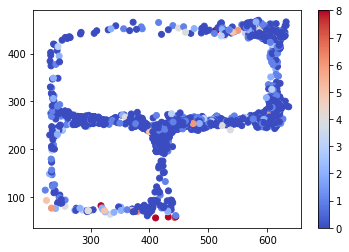

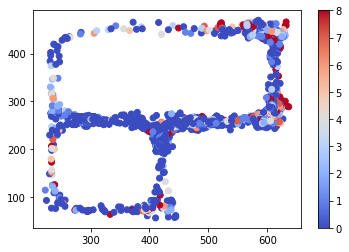

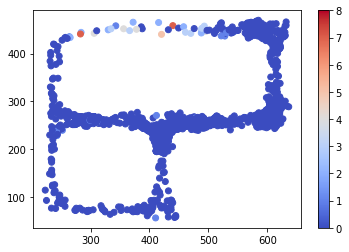

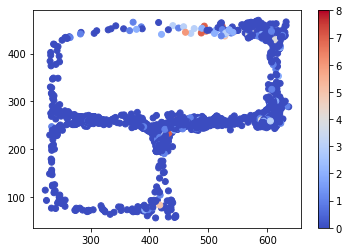

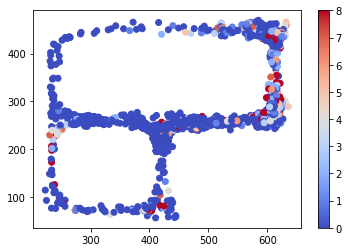

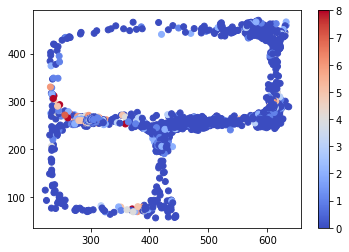

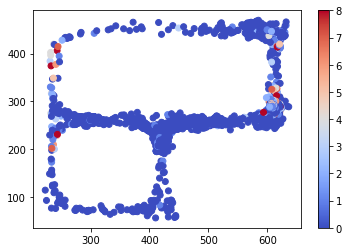

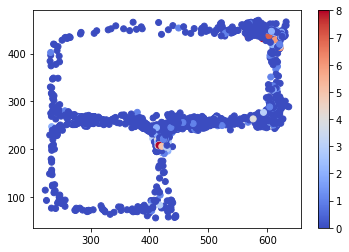

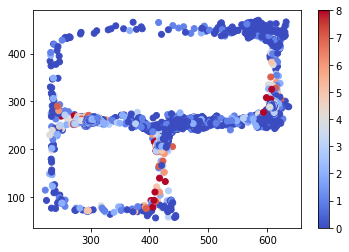

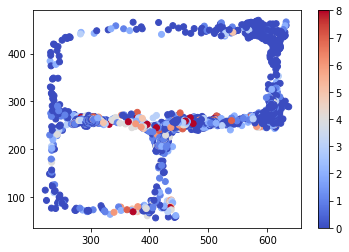

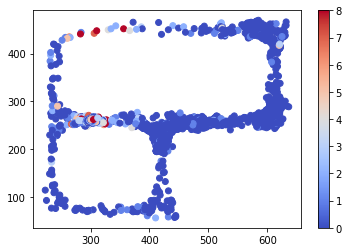

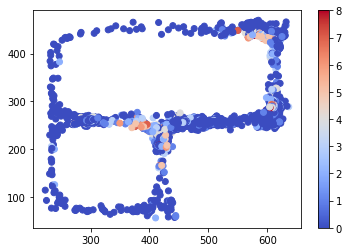

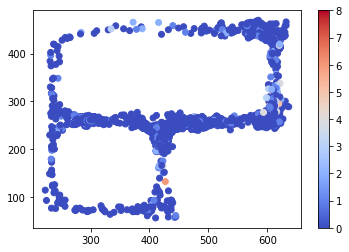

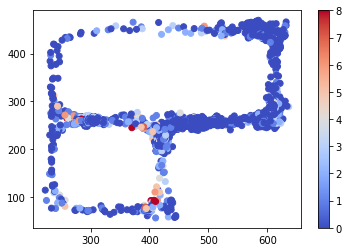

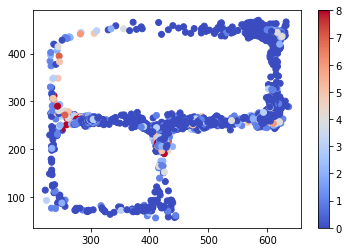

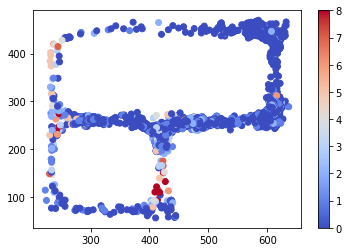

In [5]:
for i in range(neuron_num):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8)
    fig.colorbar(mappable)
    plt.show()
fig.savefig("img.png")

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 50,
 'u_dim': 1,
 'factors_dim': 2,
 'g0_encoder_dim': 50,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 8526


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 3
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [ ]:
model.fit(train_ds, valid_ds, max_epochs=800, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

Beginning training...
Epoch:    1, Step:    67, training loss: 1067.695
Epoch:    2, Step:   134, training loss: 999.736
Epoch:    3, Step:   201, training loss: 977.459
Epoch:    4, Step:   268, training loss: 955.382
Epoch:    5, Step:   335, training loss: 944.862
Epoch:    6, Step:   402, training loss: 937.859
Epoch:    7, Step:   469, training loss: 931.136
Epoch:    8, Step:   536, training loss: 928.463
Epoch:    9, Step:   603, training loss: 926.384
Epoch:   10, Step:   670, training loss: 919.756
Epoch:   11, Step:   737, training loss: 922.368
Epoch:   12, Step:   804, training loss: 918.252
Epoch:   13, Step:   871, training loss: 920.059
Epoch:   14, Step:   938, training loss: 912.948
Epoch:   15, Step:  1005, training loss: 911.600
Epoch:   16, Step:  1072, training loss: 912.091
Epoch:   17, Step:  1139, training loss: 911.868
Epoch:   18, Step:  1206, training loss: 905.880
Epoch:   19, Step:  1273, training loss: 916.503
Epoch:   20, Step:  1340, training loss: 906.6

## Load checkpoint with lowest validation error 

In [ ]:
#model.load_checkpoint('best')

## Plot results summary 

In [ ]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros(((all_time-start_time),2))
gg = int(NRep/batch_size)
for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:]=t[i][j].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)

In [ ]:
import funs
qz_mean_est = tt
#plt.plot(qz_mean_est[:,0])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
#plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')

In [ ]:
np.savetxt('lfads_k09.csv', qz_est_norm_R, delimiter=',')